In [3]:
import pandas as pd 
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import pairwise_kernels
from random import sample
import random

(CVXPY) Apr 12 06:35:29 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/cherian/opt/miniconda3/envs/conformal-gan/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: '@rpath/libmkl_rt.2.dylib'\n  Referenced from: '/Users/cherian/opt/miniconda3/envs/conformal-gan/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so'\n  Reason: tried: '/Users/cherian/opt/miniconda3/envs/conformal-gan/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/cherian/opt/miniconda3/envs/conformal-gan/lib/python3.10/site-packages/../../libmkl_rt.2.dylib' (no such file), '/Users/cherian/opt/miniconda3/envs/conformal-gan/bin/../lib/libmkl_rt.2.dylib' (no such file), '/Users/cherian/opt/miniconda3/envs/conformal-gan/bin/../lib/libmkl_rt.2.dylib' (no such file), '/usr/local/lib/libmkl_rt.2.dylib' (no such file), '/usr/lib/libmkl_rt.2.dylib' (no such file)")


In [139]:
def get_wc_cov(res, methods):
    method_wc_cov = {m : [] for m in methods}
    method_wc_std = {}
    for r in res:
        x = r['x_test'].T.astype(float)
        x /= x.sum(axis=1, keepdims=1)
        for i, method in enumerate(methods):
            coverage = r['coverage'][i].reshape(-1,1)
            wc_cov = x @ coverage
            method_wc_cov[method].append(wc_cov)
    return method_wc_cov

with open('/Users/cherian/Projects/conformal-gan/results_big.pkl', 'rb') as fp:
    res = pickle.load(fp)

methods = "ols-split ols-cc ols-ccrand qr-split qr-cc qr-ccrand qrf-split qrf-cc qrf-ccrand".split(" ")
y = get_wc_cov(res, methods)

In [276]:
import pickle

def get_wc_cov(res, methods):
    method_wc_cov = {m : [] for m in methods}
    for r in res:
        x = r['x_test'].T.astype(float)
        x /= x.sum(axis=1, keepdims=1)
        for i, method in enumerate(methods):
            coverage = r['coverage'][i].reshape(-1,1)
            wc_cov = x @ coverage
            method_wc_cov[method].append(wc_cov)
            
    wc_cov_max = {
        k : np.argmax(np.asarray(wc_cov_val).mean(axis=0).flatten()) 
        for k, wc_cov_val in method_wc_cov.items()
    }
    wc_cov_largest = {k : np.asarray(val)[:,wc_cov_max[k],:].flatten() for k, val in method_wc_cov.items()}
    wc_cov_min = {
        k : np.argmin(np.asarray(wc_cov_val).mean(axis=0).flatten()) 
        for k, wc_cov_val in method_wc_cov.items()
    }
    wc_cov_smallest = {k : np.asarray(val)[:,wc_cov_min[k],:].flatten() for k, val in method_wc_cov.items()}
    
    return wc_cov_largest, wc_cov_smallest

def get_marg_cov(res, methods):
    method_covs = {m : [] for m in methods}
    for r in res:
        for i, method in enumerate(methods):
            covs = r['coverage'][i].flatten()
            method_covs[method].append(np.mean(covs))
    return method_covs

def get_lengths(res, methods):
    method_lengths = {m : [] for m in methods}
    for r in res:
        x = r['x_test'].T
        x = x / np.sum(x, axis=1).reshape(-1,1)
        for i, method in enumerate(methods):
            lengths = r['length'][i].flatten()
            method_lengths[method].append(np.median(lengths))
    return method_lengths

experiment = "big"
with open(f'/Users/cherian/Projects/conformal-gan_results/results_{experiment}.pkl', 'rb') as fp:
    res = pickle.load(fp)
    
with open(f'/Users/cherian/Projects/conformal-gan_results/results_{experiment}_qrf.pkl', 'rb') as fp:
    res_qrf = pickle.load(fp)

methods = "ols-split ols-cc ols-ccrand qr-split qr-cc qr-ccrand qrf-split qrf-cc qrf-ccrand".split(" ")
x_dim = res[0]['x_test'].shape[1]
wc_cov_over, wc_cov_under = get_wc_cov(res, methods)
lengths = get_lengths(res, methods)
marg_cov = get_marg_cov(res, methods)

if experiment == "big":
    methods = "qrf-split".split(" ")
    x_dim = res_qrf[0]['x_test'].shape[1]
    wc_cov_over_qrf, wc_cov_under_qrf = get_wc_cov(res_qrf, methods)
    lengths_qrf = get_lengths(res_qrf, methods)
    marg_cov_qrf = get_marg_cov(res_qrf, methods)

    wc_cov_over['qrf-split'] = wc_cov_over_qrf['qrf-split']
    wc_cov_under['qrf-split'] = wc_cov_under_qrf['qrf-split']
    lengths['qrf-split'] = lengths_qrf['qrf-split']
    marg_cov['qrf-split'] = marg_cov_qrf['qrf-split']

In [277]:
res[0]['x_test']

array([[4.8e+01, 6.0e-02, 4.7e-01, ..., 0.0e+00, 0.0e+00, 1.0e+00],
       [4.0e+00, 1.0e-02, 7.7e-01, ..., 4.0e-02, 0.0e+00, 1.0e+00],
       [5.0e+00, 2.0e-02, 3.8e-01, ..., 0.0e+00, 0.0e+00, 1.0e+00],
       ...,
       [6.0e+00, 9.0e-02, 2.8e-01, ..., 5.2e-01, 0.0e+00, 1.0e+00],
       [3.7e+01, 2.0e-02, 3.7e-01, ..., 2.0e-02, 0.0e+00, 1.0e+00],
       [5.5e+01, 1.0e-02, 4.7e-01, ..., 1.7e-01, 0.0e+00, 1.0e+00]],
      dtype=float16)

In [278]:
rep_dict = {"Base Model": {"ols": "OLS", "qr": "QR", "qrf": "QRF"},
            "Method": {"split": "Split Conformal", 
                       "cc": "Conditional Calibration (Unrandomized)", 
                       "ccrand": "Conditional Calibration (Randomized)"}}

df_cov_over = pd.DataFrame(wc_cov_over)
df_cov_over = df_cov_over.melt(var_name="Method", value_name="Largest Coverage")
df_cov_over['Smallest Miscoverage'] = 1 - df_cov_over['Largest Coverage']
df_cov_over['Base Model'] = df_cov_over["Method"].apply(lambda x : x.split("-")[0])
df_cov_over['Method'] = df_cov_over["Method"].apply(lambda x : x.split("-")[1])
df_cov_over = df_cov_over.replace(rep_dict)

df_cov_under = pd.DataFrame(wc_cov_under)
df_cov_under = df_cov_under.melt(var_name="Method", value_name="Smallest Coverage")
df_cov_under['Largest Miscoverage'] = 1 - df_cov_under['Smallest Coverage']
df_cov_under['Base Model'] = df_cov_under["Method"].apply(lambda x : x.split("-")[0])
df_cov_under['Method'] = df_cov_under["Method"].apply(lambda x : x.split("-")[1])
df_cov_under = df_cov_under.replace(rep_dict)

df_l = pd.DataFrame(lengths)
df_l = df_l.melt(var_name="Method", value_name="Length")
df_l['Base Model'] = df_l["Method"].apply(lambda x : x.split("-")[0])
df_l['Method'] = df_l["Method"].apply(lambda x : x.split("-")[1])
df_l = df_l.replace(rep_dict)

df_m = pd.DataFrame(marg_cov)
df_m = df_m.melt(var_name="Method", value_name="Marginal Coverage")
df_m['Marginal Miscoverage'] = 1 - df_m['Marginal Coverage']
df_m['Base Model'] = df_m["Method"].apply(lambda x : x.split("-")[0])
df_m['Method'] = df_m["Method"].apply(lambda x : x.split("-")[1])

df_m = df_m.replace(rep_dict)

big


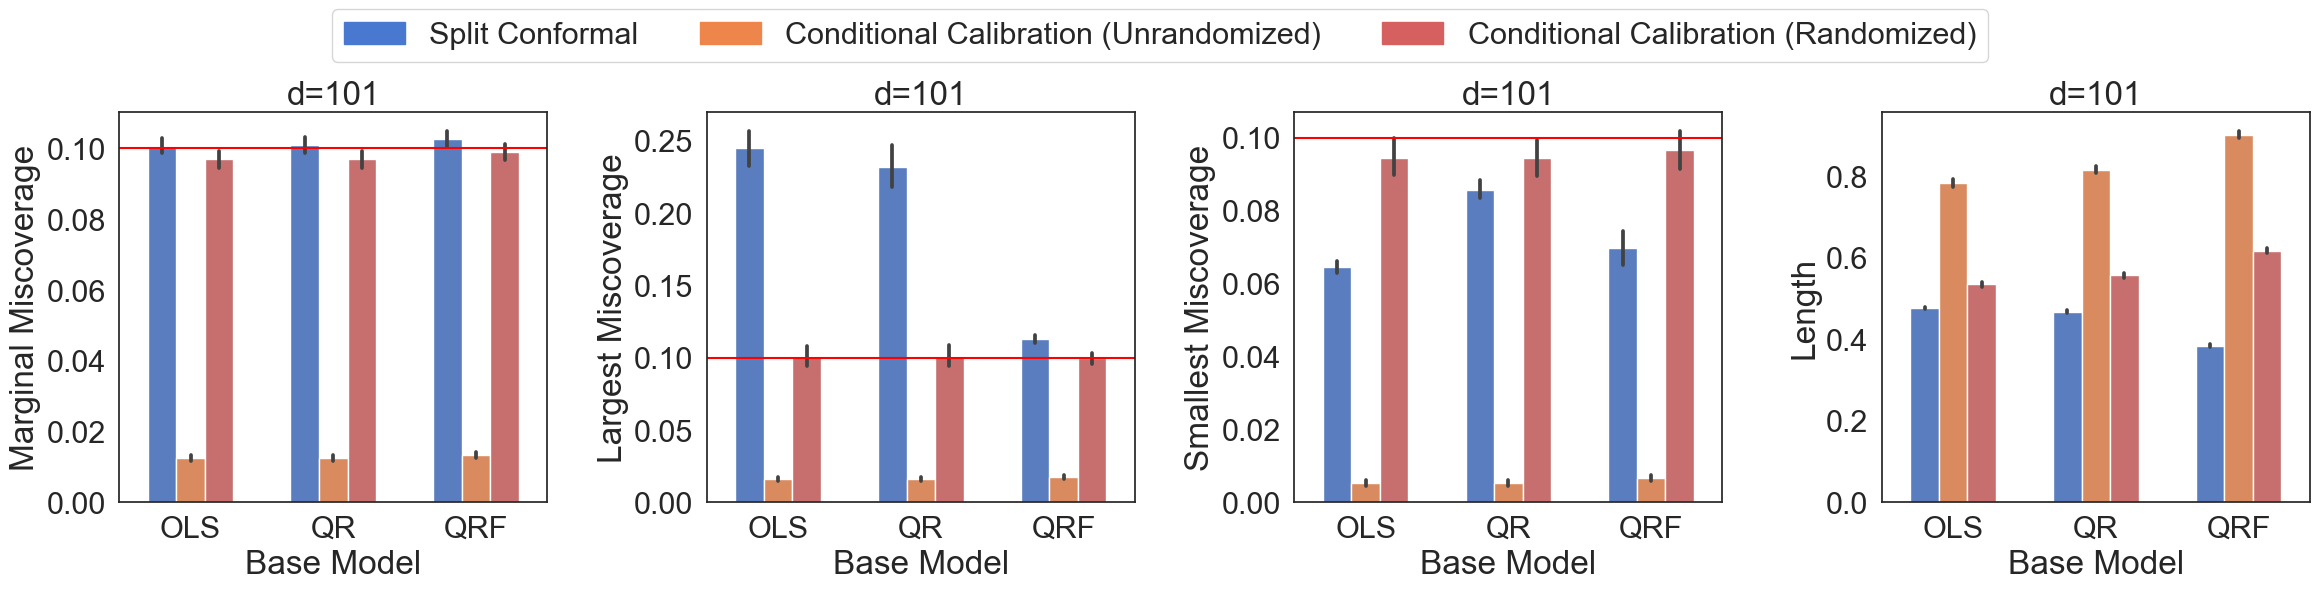

In [279]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(24,6)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

my_pal = {"Split Conformal": sns.color_palette("muted")[:][0],
          "Conditional Calibration (Unrandomized)": sns.color_palette("muted")[:][1],
         "Conditional Calibration (Randomized)": sns.color_palette("muted")[:][3]}

ax1 = fig.add_subplot(1,4,4)
f1 = sns.barplot(df_l,x='Base Model',y='Length',hue='Method',
                               palette=my_pal,ax=ax1, width=0.6)
plt.title(f'd={x_dim}')
plt.legend(title='')
plt.legend([],[], frameon=False)

ax2 = fig.add_subplot(1,4,2)
f1 = sns.barplot(df_cov_under,x='Base Model',y="Largest Miscoverage",hue='Method',
                               palette=my_pal,ax=ax2, width=0.6)
f1.axhline(0.1, color='red')
plt.title(f'd={x_dim}')
plt.legend(title='')
plt.legend([],[], frameon=False)

ax3 = fig.add_subplot(1,4,3)
f1 = sns.barplot(df_cov_over,x='Base Model',y="Smallest Miscoverage",hue='Method',
                               palette=my_pal,ax=ax3, width=0.6)
f1.axhline(0.1, color='red')
plt.title(f'd={x_dim}')
plt.legend(title='')
plt.legend([],[], frameon=False)

ax4 = fig.add_subplot(1,4,1)
f3 = sns.barplot(df_m,x='Base Model',y='Marginal Miscoverage',hue='Method',
                               palette=my_pal,ax=ax4, width=0.6)
f3.axhline(0.1, color='red')
plt.title(f'd={x_dim}')
plt.legend(title='')
plt.legend([],[], frameon=False)

import matplotlib.patches as mpatches
handles = [mpatches.Patch(color=my_pal[label], label=label) for label in my_pal]

# Adding a single legend above all subplots
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.06),
           ncol=3)
# plt.subplots_adjust(top=0.85)  # Example: Leave more space on top
plt.tight_layout(pad=1.5)
print(experiment)
plt.savefig(f"candc_{experiment}.pdf", bbox_inches='tight')

In [40]:
methods = "ols-split ols-cc ols-ccrand qr-split qrf-split qrf-ccrand".split(' ')

with open('/Users/cherian/Projects/conformal-docker/results_lp.pkl', 'rb') as fp:
    res = pickle.load(fp)

with open('/Users/cherian/Projects/conformal-docker/results_qr.pkl', 'rb') as fp:
    res_qr = pickle.load(fp)

method_lengths = {m : [] for m in methods}
for r, r_qr in zip(res, res_qr):
    for i, method in enumerate(methods):
        lengths = r['length'][i].flatten()
        if "qrf-split" in method:
            pred_lengths_qrf = r_qr['length'][1].flatten() - lengths
            lengths = lengths + pred_lengths_qrf
        elif "qrf-cc" in method:
            lengths = lengths + pred_lengths_qrf
        elif "qr-split" in method:
            pred_lengths_qr = r_qr['length'][0].flatten() - lengths
            lengths = lengths + pred_lengths_qr
        method_lengths[method].append(np.median(lengths))

method_wc_cov = {m : [] for m in methods}
for r in res:
    x = r['x_test'].T
    x = x / np.sum(x, axis=1).reshape(-1,1)
    for i, method in enumerate(methods):
        coverage_dev = r['coverage'][i].reshape(-1,1) - 0.9
        wc_cov = np.max(np.abs(x @ coverage_dev))
        method_wc_cov[method].append(wc_cov)

In [32]:
rep_dict = {"Base Model": {"ols": "OLS", "qr": "QR", "qrf": "QRF"},
            "Method": {"split": "Split Conformal", 
                       "cc": "Conditional Calibration (Unrandomized)", 
                       "ccrand": "Conditional Calibration (Randomized)"}}

df_cov = pd.DataFrame(wc_cov)
df_cov = df.melt(var_name="Method", value_name="Worst Case Conditional Coverage")
df_cov['Base Model'] = df_cov["Method"].apply(lambda x : x.split("-")[0])
df_cov['Method'] = df_cov["Method"].apply(lambda x : x.split("-")[1])

df_cov = df_cov.replace(rep_dict)

df_l = pd.DataFrame(lengths)
df_l = df_l.melt(var_name="Method", value_name="Length")
df_l['Base Model'] = df_l["Method"].apply(lambda x : x.split("-")[0])
df_l['Method'] = df_l["Method"].apply(lambda x : x.split("-")[1])

df_l = df_l.replace(rep_dict)

df_m = pd.DataFrame(marg_cov)
df_m = df_m.melt(var_name="Method", value_name="Marginal Coverage")
df_m['Base Model'] = df_m["Method"].apply(lambda x : x.split("-")[0])
df_m['Method'] = df_m["Method"].apply(lambda x : x.split("-")[1])

df_m = df_m.replace(rep_dict)

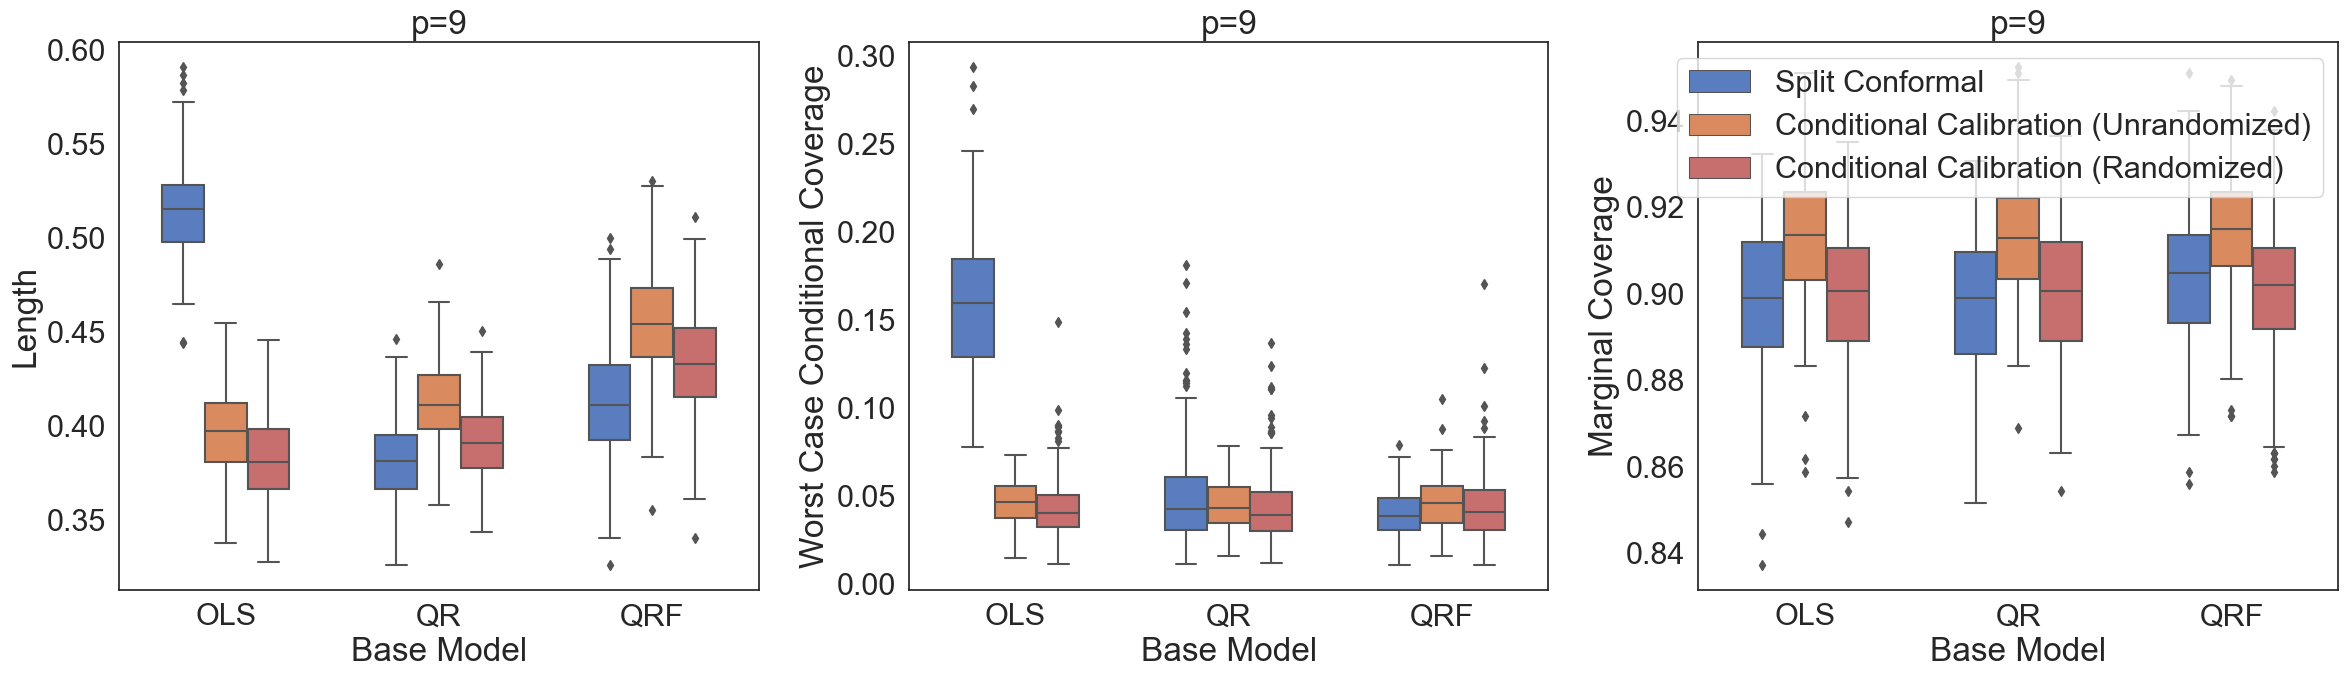

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(24,7.3)})
sns.set(font_scale=2)
sns.set_style(style='white')
fig = plt.figure()

my_pal = {"Split Conformal": sns.color_palette("muted")[:][0],
          "Conditional Calibration (Unrandomized)": sns.color_palette("muted")[:][1],
         "Conditional Calibration (Randomized)": sns.color_palette("muted")[:][3]}

ax1 = fig.add_subplot(1,3,1)
f1 = sns.boxplot(df_l,x='Base Model',y='Length',hue='Method',
                               palette=my_pal,ax=ax1, width=0.6)
plt.title('p=9')
plt.legend(title='')
plt.legend([],[], frameon=False)

ax2 = fig.add_subplot(1,3,2)
f1 = sns.boxplot(df_cov,x='Base Model',y="Worst Case Conditional Coverage",hue='Method',
                               palette=my_pal,ax=ax2, width=0.6)
plt.title('p=9')
plt.legend(title='')
plt.legend([],[], frameon=False)

ax3 = fig.add_subplot(1,3,3)
f3 = sns.boxplot(df_m,x='Base Model',y='Marginal Coverage',hue='Method',
                               palette=my_pal,ax=ax3, width=0.6)
plt.title('p=9')
plt.legend(title='')
plt.legend(loc='upper right')

plt.tight_layout()